# Testing notebook

Here we test different implemented algorithms

## Basic Block Matching

In [4]:
from block_matching import disp, disp_inv, disp_rgb, disp_inv_rgb
import block_matching
from skimage import io, color
import matplotlib.pyplot as plt
from mode_filter import mode_filter
import numpy as np
from importlib import reload

reload(block_matching)

<module 'block_matching' from '/Users/pierreadorni/Documents/depth-estimation/noml/block_matching.py'>

In [5]:
Ig = io.imread('teddy/im2.png')
Id = io.imread('teddy/im6.png')

Iggray = color.rgb2gray(Ig)
Idgray = color.rgb2gray(Id)

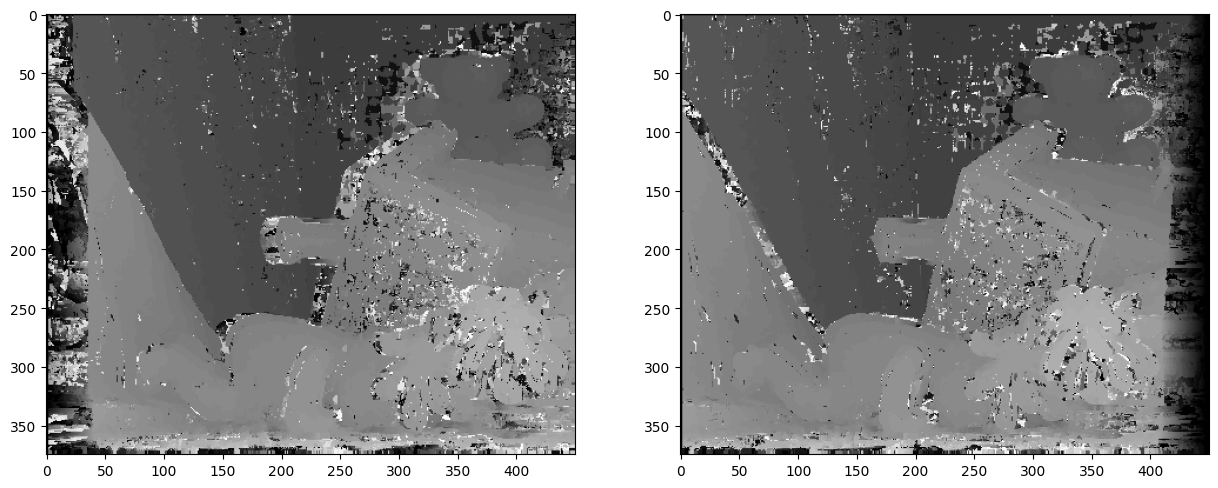

In [53]:
bm_disp_map = disp(Iggray, Idgray, 64)
bm_inv_disp_map = disp_inv(Iggray, Idgray, 64)
fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(bm_disp_map, cmap='gray')
ax[1].imshow(bm_inv_disp_map, cmap='gray')

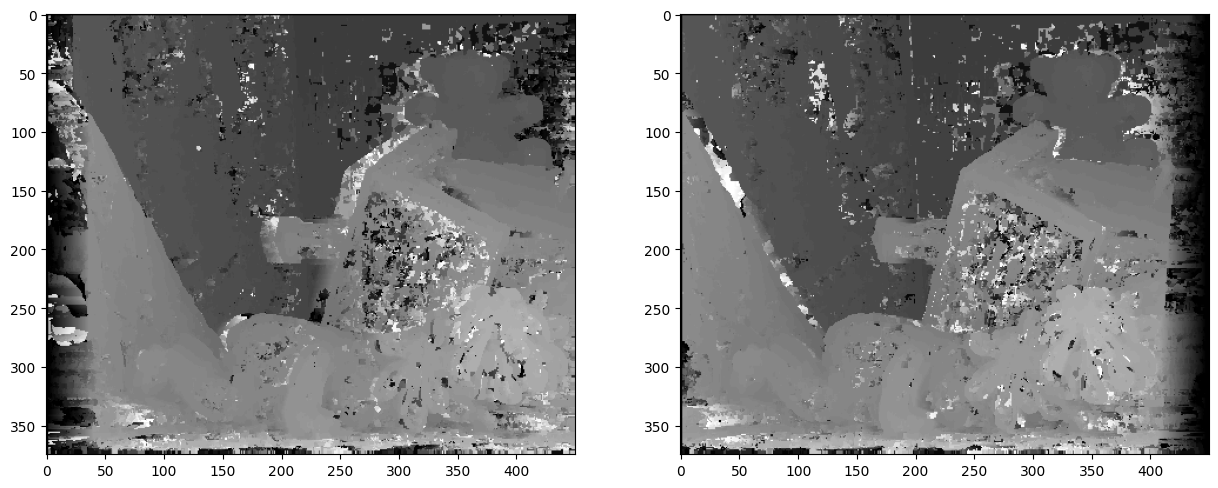

In [52]:
bm_rgb_disp_map = disp_rgb(Ig, Id, 64)
bm_rgb_inv_disp_map = disp_inv_rgb(Ig, Id, 64)
fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(bm_rgb_disp_map, cmap='gray')
ax[1].imshow(bm_rgb_inv_disp_map, cmap='gray')

In [54]:
def merge_disps(left: np.ndarray, right: np.ndarray):
    # for each pixel on the left image, go to the right image and back to the left image and check if we are still on the same pixel (approximately)
    # if not, we are on an occluded pixel
    result = left.copy()
    for j in range(left.shape[0]):
        for i in range(left.shape[1]):
            # get the disparity of the pixel
            disp = left[j, i]
            # get the pixel on the right image
            try:
                pixel_right = right[j, i - disp]
                # if the pixel on the right image is not approx. the same as the pixel on the left image, we are on an occluded pixel
                if disp < pixel_right - 10 or disp > pixel_right + 10:
                    result[j, i] = 0
            except IndexError:
                result[j, i] = 0

    return result

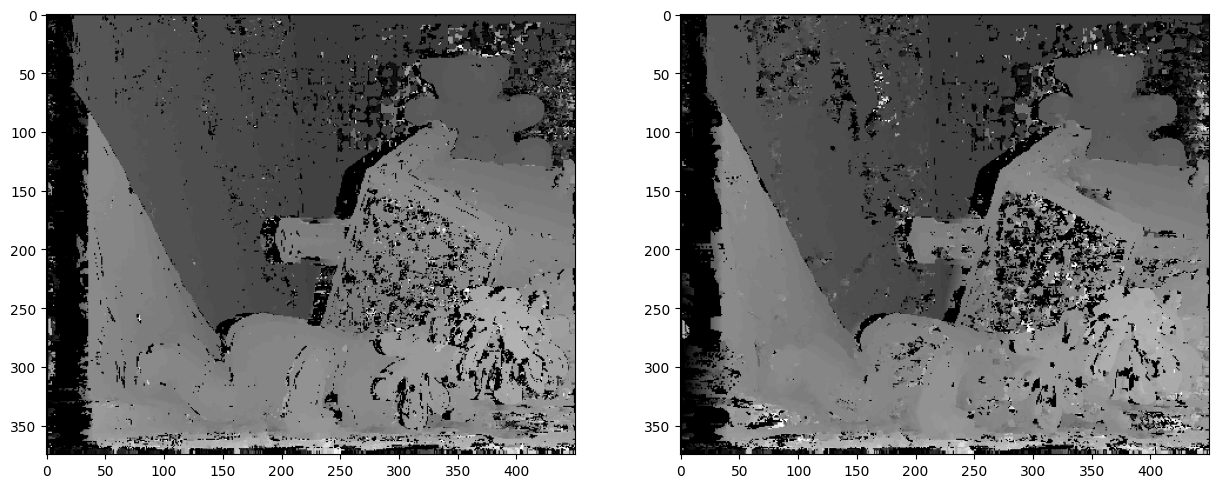

In [55]:
merged_disp_map = merge_disps(bm_disp_map.astype(np.uint16), bm_inv_disp_map.astype(np.uint16))
merged_rgb_disp_map = merge_disps(bm_rgb_disp_map.astype(np.uint16), bm_rgb_inv_disp_map.astype(np.uint16))
fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(merged_disp_map, cmap='gray')
ax[1].imshow(merged_rgb_disp_map, cmap='gray')

In [56]:
def mode_filter_occl(disp_map: np.ndarray, filter_size=5):
    """
    Apply a mode filter to the disparity map
    :param disp_map: disparity map
    :param filter_size: size of the filter, defaults to 5
    :return: filtered disparity map
    """
    disp_map_filtered = np.zeros_like(disp_map)
    for j in range(disp_map.shape[0] - filter_size):
        for i in range(disp_map.shape[1] - filter_size):
            # get the values in the filter
            values = disp_map[j:j + filter_size, i:i + filter_size]
            # compute the mode except 0
            mode = np.bincount(values.flatten().astype(int)).argmax()
            if mode == 0:
                try:
                    mode = np.bincount(values.flatten().astype(int))[1:].argmax() + 1
                except ValueError:
                    mode = 0
            # assign the mode to the center of the filter
            disp_map_filtered[j + filter_size // 2, i + filter_size // 2] = mode
    return disp_map_filtered

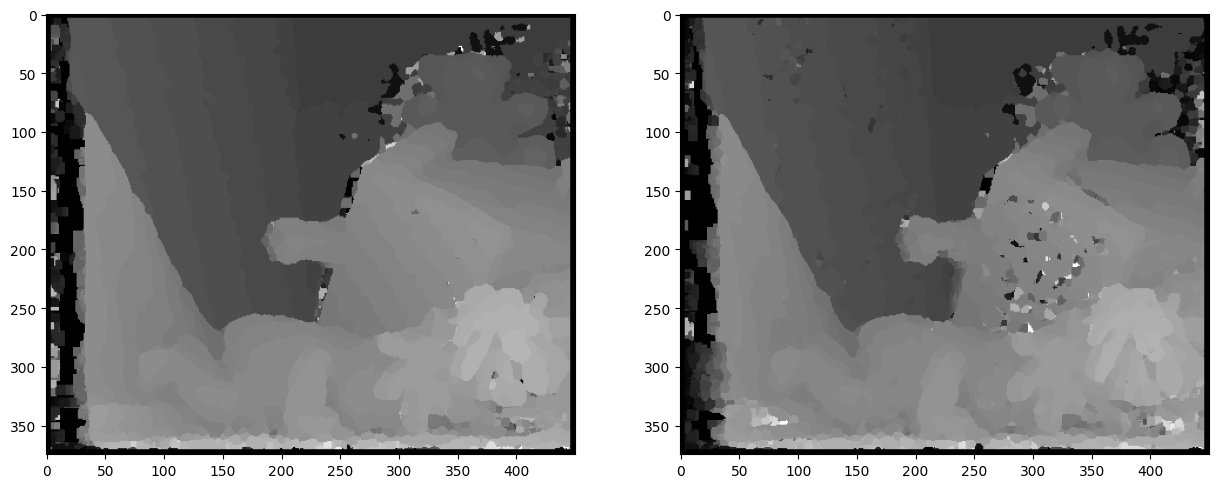

In [58]:
merged_disp_map_filtered = mode_filter_occl(merged_disp_map, 8)
merged_rgb_disp_map_filtered = mode_filter_occl(merged_rgb_disp_map, 8)
fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(merged_disp_map_filtered, cmap='gray')
ax[1].imshow(merged_rgb_disp_map_filtered, cmap='gray')

## Weighted window

### Yoon Kweon implementation

In [27]:
from yoon_kweon import yoon_kweon_diss, our_diss
import yoon_kweon
reload(yoon_kweon)

<module 'yoon_kweon' from '/Users/pierreadorni/Documents/depth-estimation/noml/yoon_kweon.py'>

In [6]:
i_ref_lab = color.rgb2lab(Ig)
i_tgt_lab = color.rgb2lab(Id)

yk_disp_map = yoon_kweon_diss(Ig, Id, i_ref_lab, i_tgt_lab, block_size=3)

NameError: name 'yoon_kweon_diss' is not defined

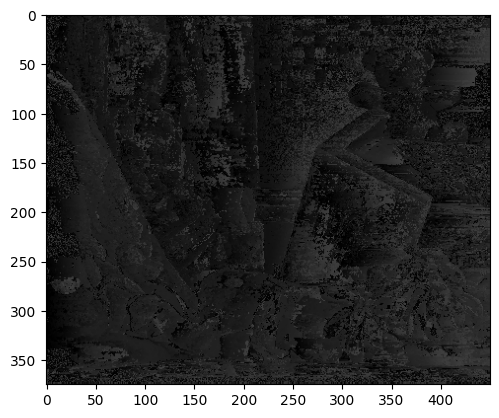

In [30]:
plt.imshow(yk_disp_map, cmap='gray')

Looking at the results, the implementation is bugged. We need to investigate it.

### Our implementation

In [218]:
from yoon_kweon import our_diss
import yoon_kweon
reload(yoon_kweon)

<module 'yoon_kweon' from '/Users/pierreadorni/Documents/depth-estimation/noml/yoon_kweon.py'>

100%|██████████| 375/375 [00:43<00:00,  8.69it/s]


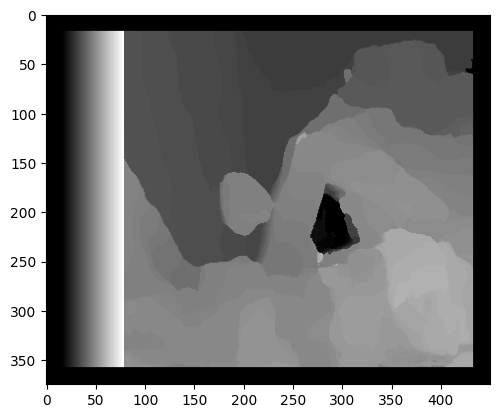

In [219]:
aw_disp_map = our_diss(Ig, Id, i_ref_lab, i_tgt_lab, block_size=35)
plt.imshow(aw_disp_map, cmap='gray')

In [231]:
io.imsave('teddy_aw_disp_map.png', aw_disp_map.astype(np.uint8)*4)

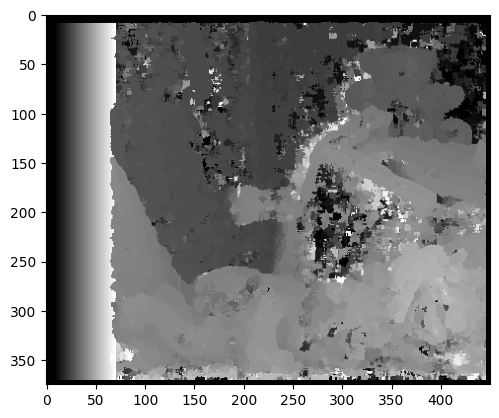

In [37]:
# apply mode filter
aw_disp_map_filtered = mode_filter(aw_disp_map, 8)
plt.imshow(aw_disp_map_filtered, cmap='gray')

C'est vraiment très très mauvais hein

In [24]:
occl_gt = io.imread('teddy/occl.png')
occl_gt.shape

(375, 450)

In [23]:
io.imsave('teddy/occl.png', occl_gt[:,:,0].astype(np.uint8))

# show window weights

In [221]:
block_size = 35
ref_block_lab = i_ref_lab[30:30+block_size, 310:310+block_size]

colorWeights = np.zeros((block_size, block_size))
distWeights = np.zeros((block_size, block_size))
for dj in range(block_size):
    for di in range(block_size):
        # weight is the color difference in LAB between the pixel and the center of the block,
        # and the Euclidean distance of the coordinates to the center of the block
        colorWeights[dj, di] = -np.linalg.norm(ref_block_lab[dj, di] - ref_block_lab[block_size // 2, block_size // 2]) ** 2
        distWeights[dj, di] = -np.linalg.norm(np.array([dj*1.0, di]) - np.array([block_size // 2, block_size // 2]))
# normalize weights
colorWeights = (colorWeights - colorWeights.min()) / (colorWeights.max() - colorWeights.min())
distWeights = (distWeights - distWeights.min()) / (distWeights.max() - distWeights.min())
weights = colorWeights * distWeights

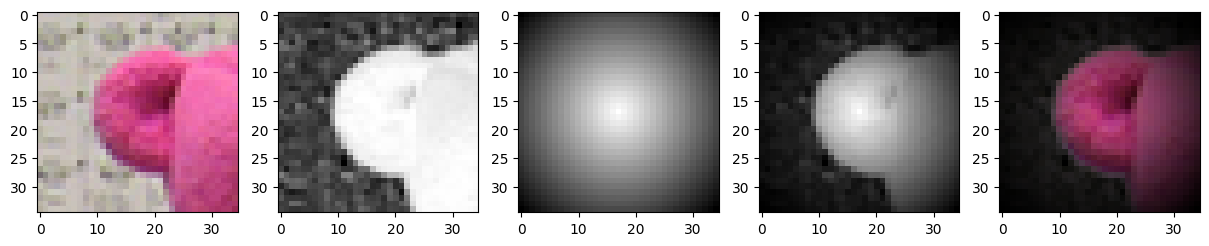

In [229]:
fig, ax = plt.subplots(1, 5, figsize=(15, 15))
ax[0].imshow((color.lab2rgb(ref_block_lab) * 255).astype(np.uint8))
ax[1].imshow(colorWeights, cmap='gray')
ax[2].imshow(distWeights, cmap='gray')
ax[3].imshow(weights, cmap='gray')
# show original window, with weights
ax[4].imshow(color.lab2rgb(ref_block_lab) * weights[:, :, np.newaxis])
io.imsave('teddy_ear.png', (color.lab2rgb(ref_block_lab) * 255).astype(np.uint8))
io.imsave('teddy_ear_color_weights.png', (colorWeights*255).astype(np.uint8))
io.imsave('teddy_ear_dist_weights.png', (distWeights*255).astype(np.uint8))
io.imsave('teddy_ear_weights.png', (weights*255).astype(np.uint8))
io.imsave('teddy_ear_weighted.png', (color.lab2rgb(ref_block_lab) * weights[:, :, np.newaxis] * 255).astype(np.uint8))

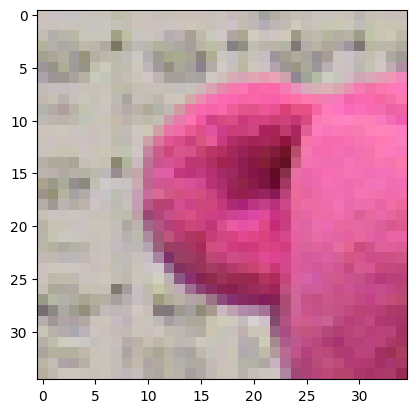

In [224]:
plt.imshow(color.lab2rgb(ref_block_lab))

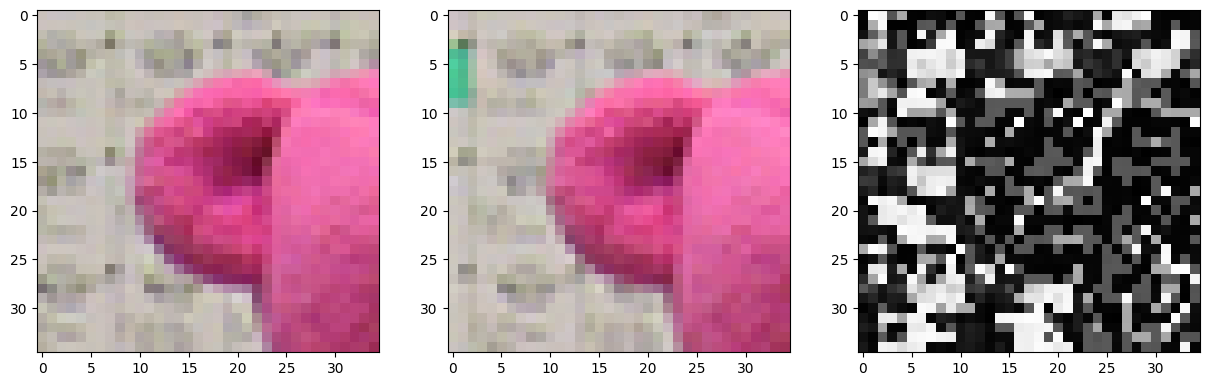

In [205]:
center = (30, 310)
block_size = 35
d = 21
block = Ig[center[0]:center[0]+block_size, center[1]:center[1]+block_size]
tgt_block = Id[center[0]:center[0] + block_size, center[1] - d :center[1] - d + block_size]
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
ax[0].imshow(block)
ax[1].imshow(tgt_block)
# use Euclidan distance of rgb components to compute the distance between the two blocks
ax[2].imshow(np.sum(np.abs(tgt_block - block), axis=2), cmap='gray')

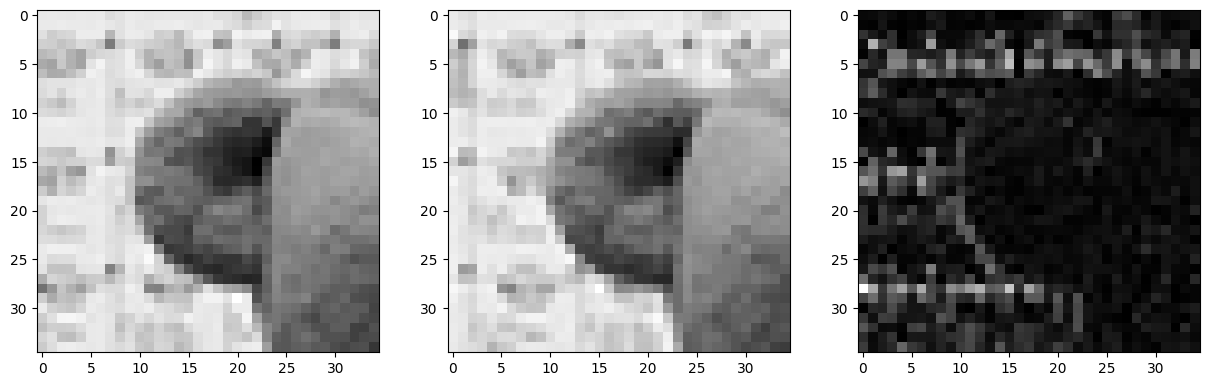

In [201]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
ax[0].imshow(color.rgb2gray(block), cmap='gray')
ax[1].imshow(color.rgb2gray(tgt_block), cmap='gray')
ax[2].imshow(np.abs(color.rgb2gray(block) - color.rgb2gray(tgt_block)), cmap='gray')

# Parameter optimization

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [109]:
df = pd.read_csv('mean_grid_search.csv', index_col=0)
df.head()

,raw,mode 3,mode 5,mode 7,mode 9,mode 11,mode no occl 3,mode no occl 5,mode no occl 7,mode no occl 9,mode no occl 11
N Teddy,,,,,,,,,,,
3,35.12,27.42,23.99,23.08,23.06,23.41,25.02,22.28,21.64,21.70,21.96
5,19.26,16.98,15.69,15.43,15.61,15.99,17.87,18.21,18.80,19.54,20.30
7,18.17,17.25,16.52,16.20,16.42,16.78,18.16,18.67,19.31,20.04,20.83
9,19.20,18.72,18.24,18.07,18.07,18.40,19.51,19.84,20.41,21.02,21.70
11,20.76,20.53,20.19,20.05,20.04,20.18,21.06,21.31,21.76,22.34,22.96


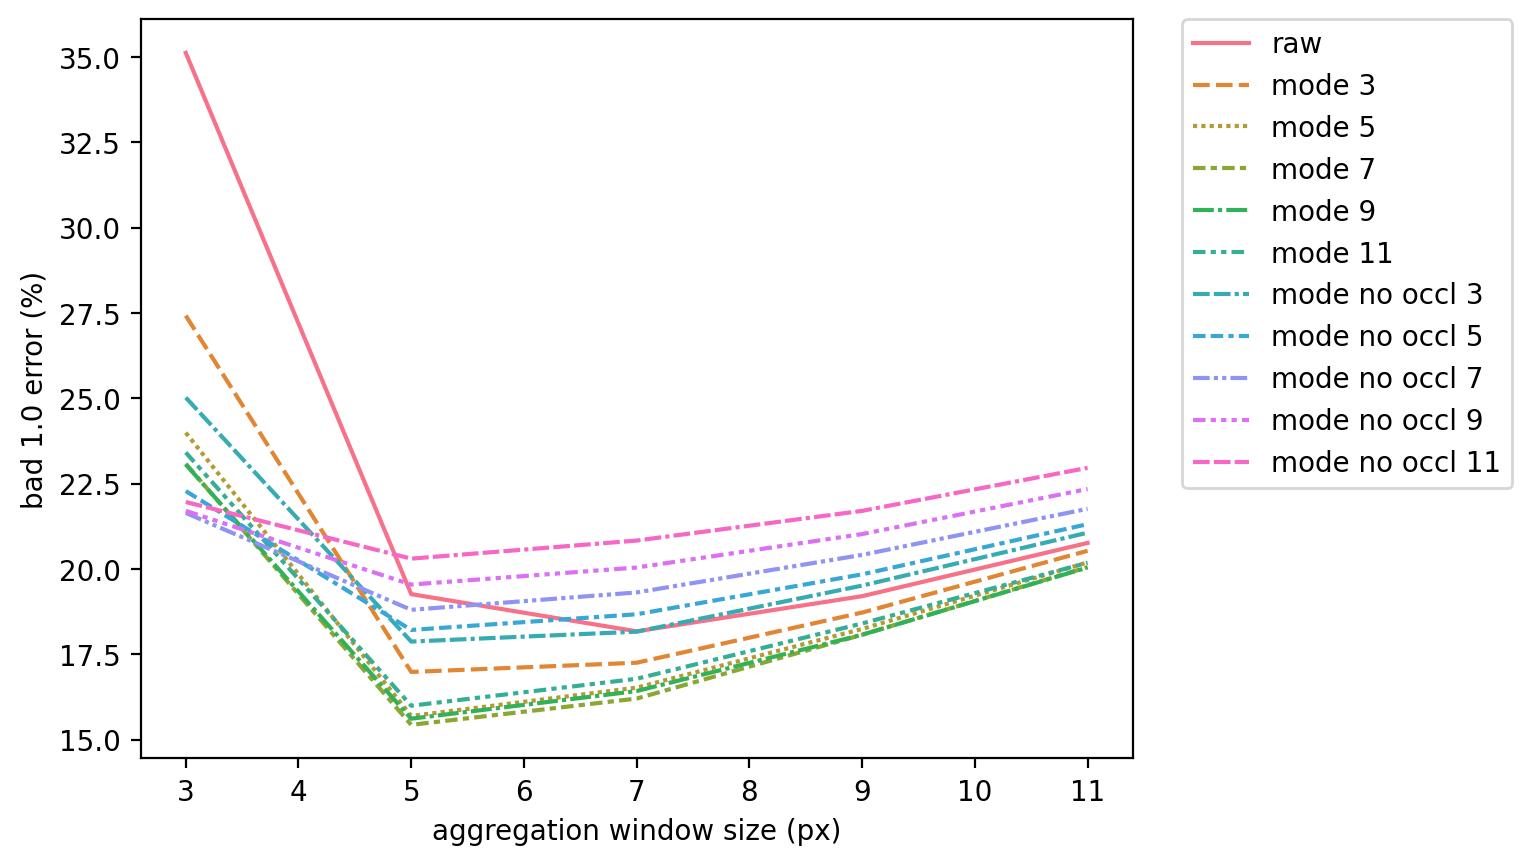

In [110]:
fig = sns.lineplot(df)
# set axes labels
plt.xlabel('aggregation window size (px)')
plt.ylabel('bad 1.0 error (%)')
# put legend out
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [98]:
# convert df to long format, use index col as id_vars
df = df.melt(id_vars=['N'], var_name='mode', value_name='error')
df

,N,mode,error
0,3,raw,42.51
1,5,raw,22.80
2,7,raw,19.72
3,9,raw,20.04
4,11,raw,21.36
5,3,mode 3,35.21
6,5,mode 3,19.89
7,7,mode 3,18.44
8,9,mode 3,19.34
9,11,mode 3,20.98


Text(0, 0.5, 'bad 1.0 error (%)')

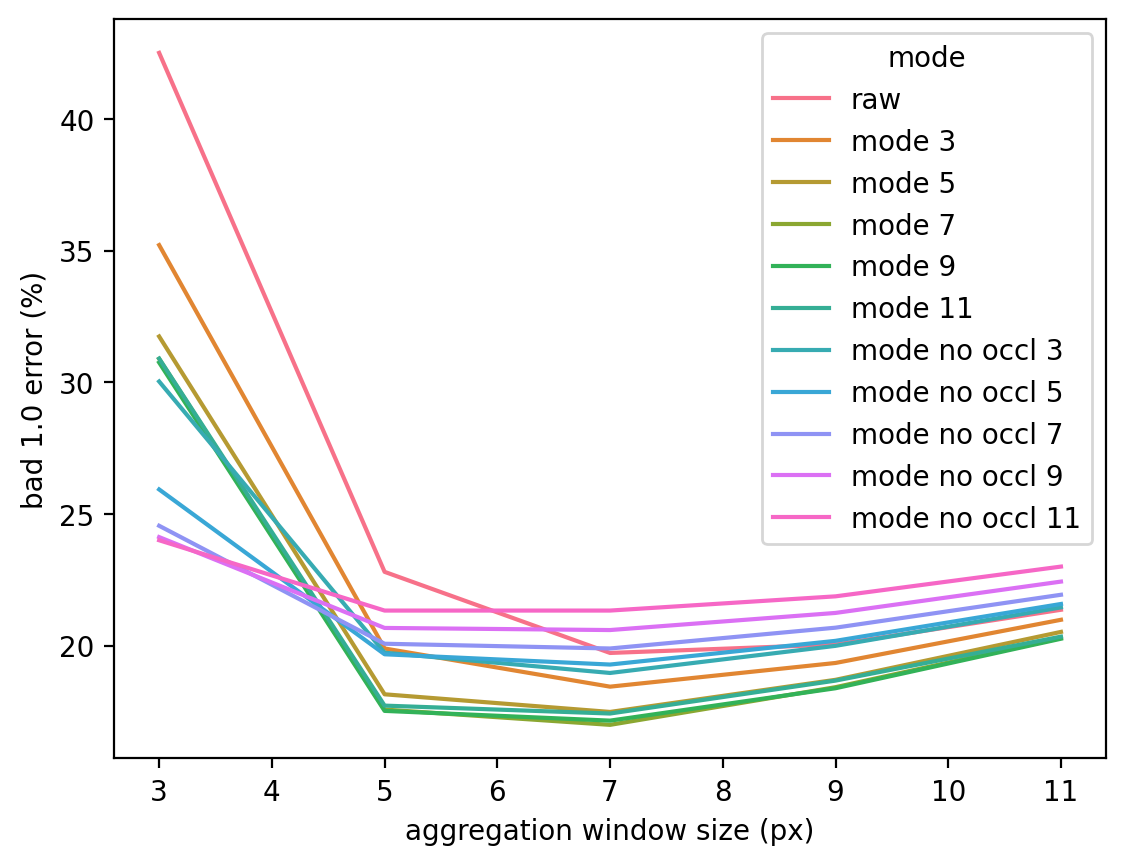

In [99]:
fig = sns.lineplot(df, hue='mode', x="N", y="error")
# set axes labels
plt.xlabel('aggregation window size (px)')
plt.ylabel('bad 1.0 error (%)')

In [51]:
df_with_occl = df[df['mode'].str.contains('occl') == False]
df_without_occl = df[df['mode'].str.contains('occl') == True]

In [56]:
# change the mode from string to int (raw = 1, mode 3 = 3, mode 5 = 5, mode 7 = 7, mode 9 = 9, mode 11 = 11)
df_with_occl['mode'] = df_with_occl['mode'].str.replace('raw', '1')
df_with_occl['mode'] = df_with_occl['mode'].str.replace('mode ', '')
df_with_occl['mode'] = df_with_occl['mode'].astype(int)
df_with_occl

/var/folders/vy/3mddc3k94cndwb3m749bkfpr0000gn/T/ipykernel_22895/4157017766.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_occl['mode'] = df_with_occl['mode'].str.replace('raw', '1')
/var/folders/vy/3mddc3k94cndwb3m749bkfpr0000gn/T/ipykernel_22895/4157017766.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_occl['mode'] = df_with_occl['mode'].str.replace('mode ', '')
/var/folders/vy/3mddc3k94cndwb3m749bkfpr0000gn/T/ipykernel_22895/4157017766.py:4: SettingWithCopyWarning: 
A value is t

,N,mode,error
0,3,1,42.51
1,5,1,22.80
2,7,1,19.72
3,9,1,20.04
4,11,1,21.36
5,3,3,35.21
6,5,3,19.89
7,7,3,18.44
8,9,3,19.34
9,11,3,20.98


In [81]:
df_with_occl[df_with_occl['mode'] == 1]

,N,mode,error
0,3,1,42.51
1,5,1,22.80
2,7,1,19.72
3,9,1,20.04
4,11,1,21.36


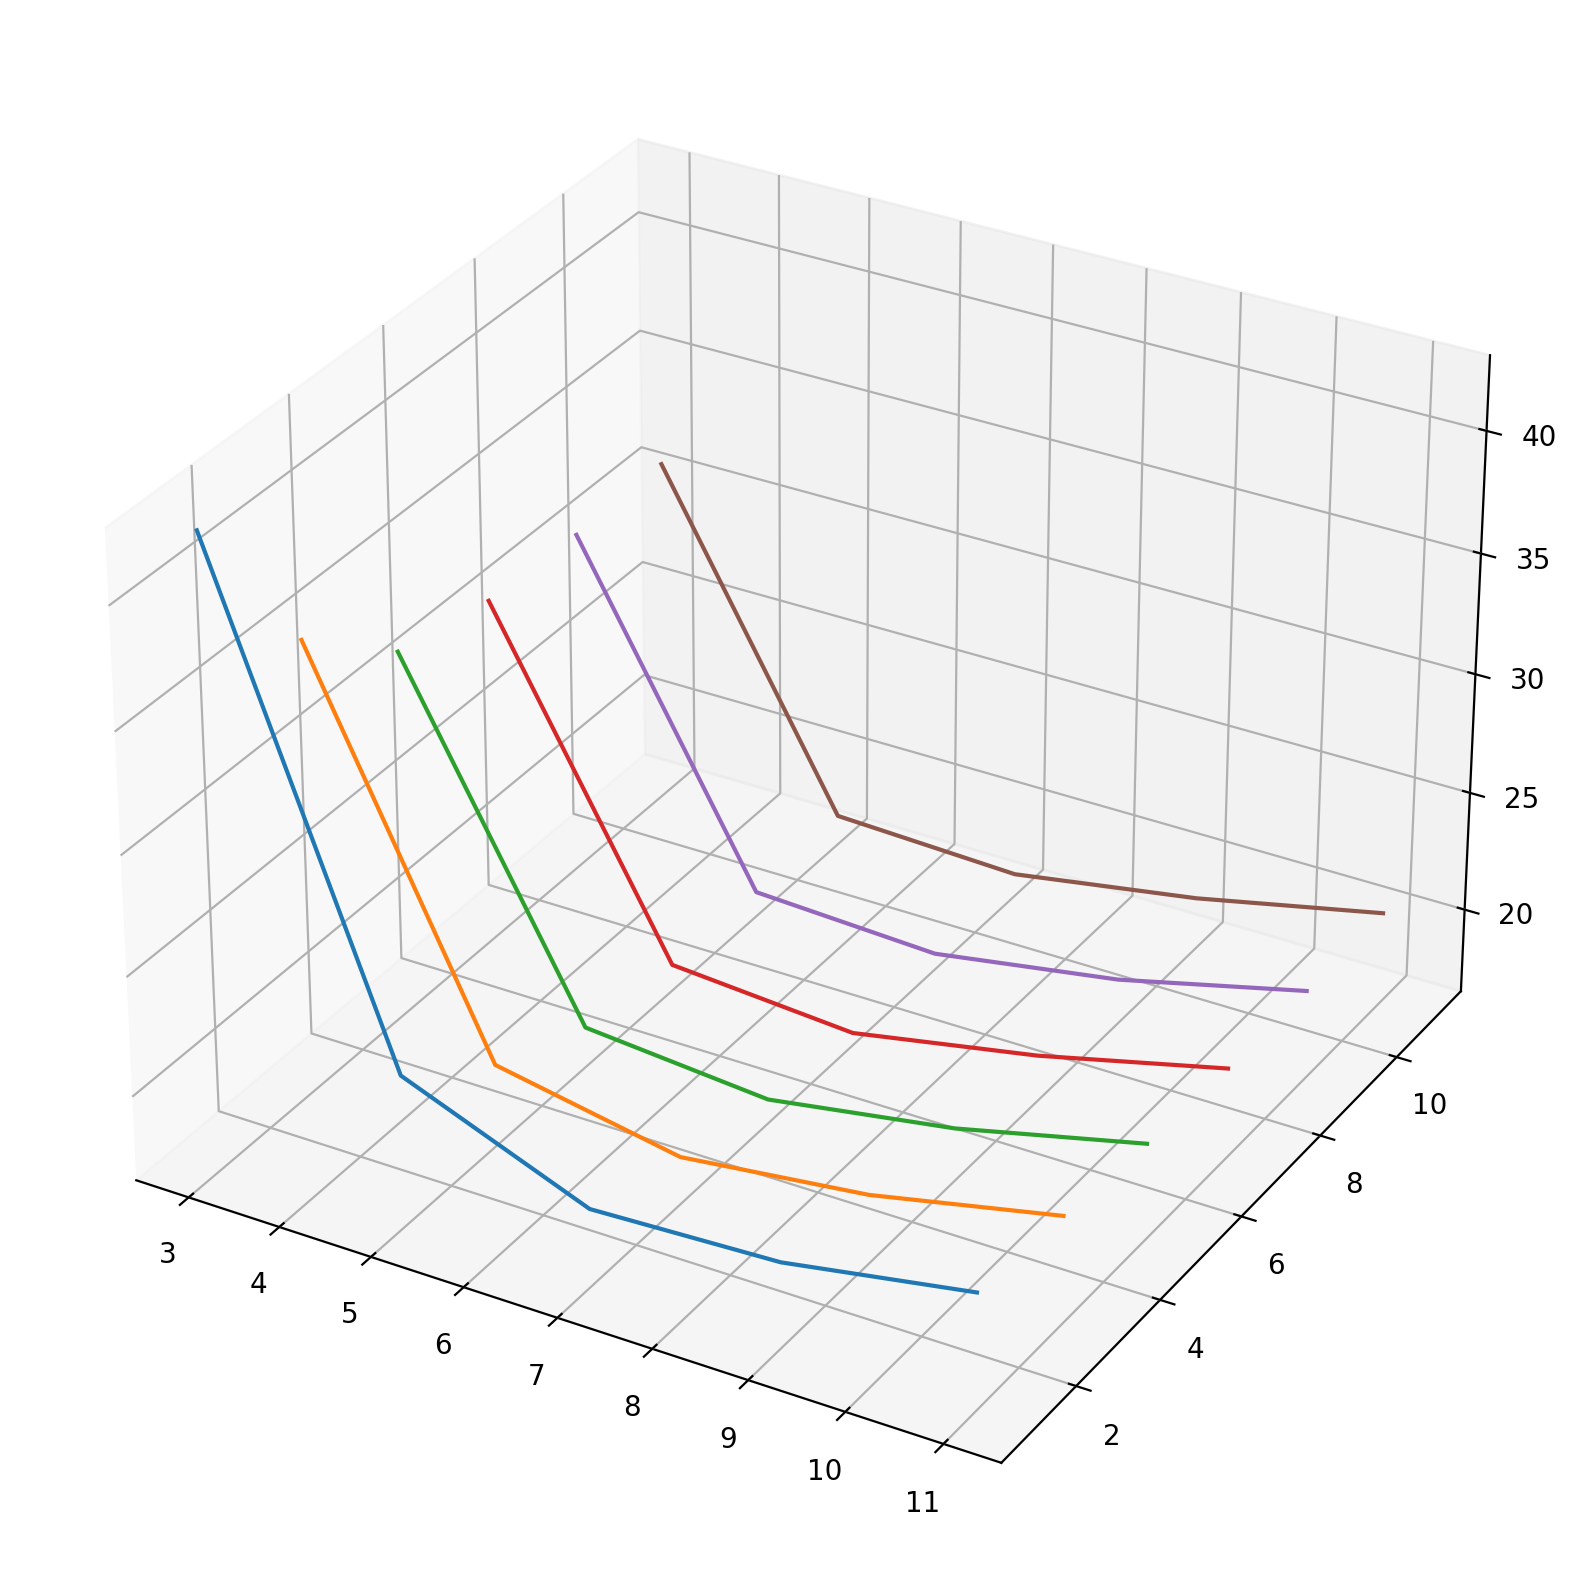

In [86]:
# 3d plot of the error as a function of the window size and the mode
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
# 'mode' is the mode name
# 'N' is the window size
# 'error' is the error
ax.plot3D(df_with_occl[df_with_occl['mode'] == 1]['N'], df_with_occl[df_with_occl['mode'] == 1]['mode'], df_with_occl[df_with_occl['mode'] == 1]['error'])
ax.plot3D(df_with_occl[df_with_occl['mode'] == 3]['N'], df_with_occl[df_with_occl['mode'] == 3]['mode'], df_with_occl[df_with_occl['mode'] == 3]['error'])
ax.plot3D(df_with_occl[df_with_occl['mode'] == 5]['N'], df_with_occl[df_with_occl['mode'] == 5]['mode'], df_with_occl[df_with_occl['mode'] == 5]['error'])
ax.plot3D(df_with_occl[df_with_occl['mode'] == 7]['N'], df_with_occl[df_with_occl['mode'] == 7]['mode'], df_with_occl[df_with_occl['mode'] == 7]['error'])
ax.plot3D(df_with_occl[df_with_occl['mode'] == 9]['N'], df_with_occl[df_with_occl['mode'] == 9]['mode'], df_with_occl[df_with_occl['mode'] == 9]['error'])
ax.plot3D(df_with_occl[df_with_occl['mode'] == 11]['N'], df_with_occl[df_with_occl['mode'] == 11]['mode'], df_with_occl[df_with_occl['mode'] == 11]['error'])